In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [172]:
#Loading in data sets
def get_data(week_nums):
    path = 'data/turnstile_{}.txt'
    dfs = []
    for week in weeks:
        file_path = path.format(week)
        dfs.append(pd.read_csv(file_path))
    return pd.concat(dfs)

weeks = [210102,210109,210116,210123,210130,210206,210213,210220,210227,210306,210313,210320,210327]
turnstile_df = get_data(weeks)

In [173]:
start_df = pd.read_csv('data/turnstile_210327.txt')
start_df['DIFF'] = start_df.ENTRIES.diff()
start_df = start_df[start_df.DIFF.isna() == False]
start_df = start_df[start_df.DIFF >= 0]
start_df['DATETIME'] = pd.to_datetime(start_df.DATE + " " + start_df.TIME, format='%m/%d/%Y %H:%M:%S')
start_df['wkday_num'] = start_df.DATETIME.dt.dayofweek

In [189]:
#Our feature of interest is daily traffic, so we must engineer this by using the difference between subsequent ENTRIES
turnstile_df['DAILY_ENTRIES'] = turnstile_df.ENTRIES.diff()
turnstile_df = turnstile_df[turnstile_df.DAILY_ENTRIES.isna() == False]
turnstile_df = turnstile_df[turnstile_df.DAILY_ENTRIES >= 0]
#In our process of cleaning, we can remove some obvious unnecessary data points.

In [190]:
turnstile_df1 = turnstile_df[turnstile_df.DAILY_ENTRIES == turnstile_df.DAILY_ENTRIES.max()]
turnstile_df[turnstile_df.DAILY_ENTRIES > 20000]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DAILY_ENTRIES
130,A002,R051,02-03-01,59 ST,NQR456W,BMT,12/26/2020,07:00:00,REGULAR,1529857,2379994,122087.0
173,A002,R051,02-03-02,59 ST,NQR456W,BMT,12/26/2020,07:00:00,REGULAR,6612656,8827979,5080299.0
259,A002,R051,02-03-04,59 ST,NQR456W,BMT,12/26/2020,07:00:00,REGULAR,7518562,3876057,1409421.0
302,A002,R051,02-03-05,59 ST,NQR456W,BMT,12/26/2020,07:00:00,REGULAR,12069702,1454705,4549067.0
464,A002,R051,02-06-00,59 ST,NQR456W,BMT,12/26/2020,07:00:00,REGULAR,74737,10937,74737.0
...,...,...,...,...,...,...,...,...,...,...,...,...
209051,TRAM1,R468,00-00-00,RIT-MANHATTAN,R,RIT,03/20/2021,05:00:00,REGULAR,936159,20245,935539.0
209135,TRAM1,R468,00-00-02,RIT-MANHATTAN,R,RIT,03/20/2021,05:00:00,REGULAR,317511,6198,56163.0
209219,TRAM2,R469,00-00-00,RIT-ROOSEVELT,R,RIT,03/20/2021,05:00:00,REGULAR,762914,18577,762409.0
209261,TRAM2,R469,00-00-01,RIT-ROOSEVELT,R,RIT,03/20/2021,05:00:00,REGULAR,3672814,49384,2904356.0


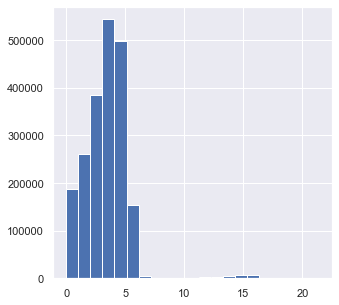

In [191]:
#Due the outliers resulting in incredibly large numbers, we used a logarithm to more easily identify the outliers. It seems
#We could omit values greater than ~450.
num_x = turnstile_df.DAILY_ENTRIES.apply(np.log)
num_x = num_x.replace(-np.inf, np.nan)
plt.hist(num_x, 21)
plt.savefig('plots/outliers.png')

In [194]:
turnstile_df = turnstile_df[turnstile_df.DAILY_ENTRIES < 500]
turnstile_df.DAILY_ENTRIES.max() # This shows that the maximum value is well under our upper bound, ensuring we're not
                                 # excluding important data points.


499.0

In [84]:
# We would like to inform our clientele of the best places to perform on a given weekday.
turnstile_df['DATETIME'] = pd.to_datetime(turnstile_df.DATE + " " + turnstile_df.TIME, format='%m/%d/%Y %H:%M:%S')
turnstile_df['WEEKDAY'] = turnstile_df.DATETIME.dt.dayofweek

mon_df = turnstile_df[turnstile_df.WEEKDAY == 0]
tue_df = turnstile_df[turnstile_df.WEEKDAY == 1]
wed_df = turnstile_df[turnstile_df.WEEKDAY == 2]
thu_df = turnstile_df[turnstile_df.WEEKDAY == 3]
fri_df = turnstile_df[turnstile_df.WEEKDAY == 4]
sat_df = turnstile_df[turnstile_df.WEEKDAY == 5]
sun_df = turnstile_df[turnstile_df.WEEKDAY == 6]

In [147]:
# We're now going to discover which stations have the most entries on Mondays
mon_results = mon_df.groupby(['STATION'])[['DAILY_ENTRIES']].median().reset_index().sort_values(by='DAILY_ENTRIES', ascending = False).head(10)
mon_results

,STATION,DAILY_ENTRIES
287,MYRTLE AV,153.5
54,3 AV 138 ST,129.5
171,BURNSIDE AV,128.5
114,90 ST-ELMHURST,127.5
2,103 ST-CORONA,122.0
312,PARKSIDE AV,116.5
367,WESTCHESTER SQ,108.0
191,CORTELYOU RD,104.5
119,ALLERTON AV,103.0
227,GATES AV,101.0


<Figure size 720x432 with 0 Axes>

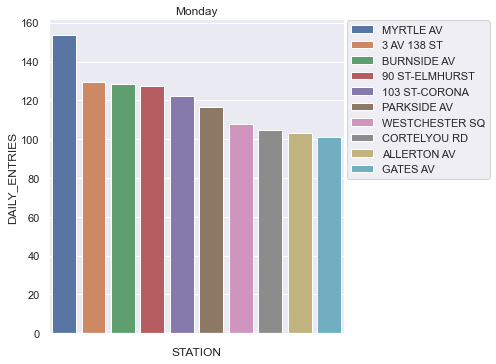

In [163]:
#sns.catplot(x = 'STATION', y = 'DAILY_ENTRIES', data = mon_results, kind = 'bar').set_xticklabels([])
#plt.bar(mon_results.STATION, mon_results.DAILY_ENTRIES)
plt.figure(figsize=(10,6))
sns.catplot(x = 'STATION', y = 'DAILY_ENTRIES', data = mon_results, kind = 'bar', hue = 'STATION', dodge = False).set_xticklabels([])
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
plt.title('Monday')
plt.savefig('mon.png')

<Figure size 720x432 with 0 Axes>

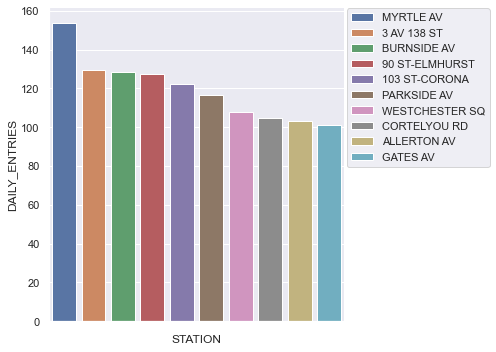

In [150]:
def create_bar_plot(data):
    plt.figure(figsize=(10,6))
    sns.catplot(x='STATION', y='DAILY_ENTRIES', data=data, hue='STATION', kind='bar', dodge = False).set_xticklabels([])
    plt.legend(bbox_to_anchor = (1.01,1), borderaxespad = 0)
    
create_bar_plot(mon_results)

In [152]:
def create_results(df):
    result = df.groupby(['STATION'])[['DAILY_ENTRIES']].median().reset_index().sort_values(by='DAILY_ENTRIES', ascending = False).head(10)
    return result

<Figure size 720x432 with 0 Axes>

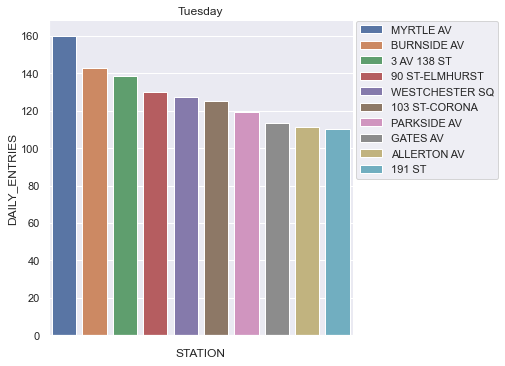

In [164]:
tue_results = create_results(tue_df)
create_bar_plot(tue_results)
plt.title('Tuesday')
plt.savefig('tue.png')

<Figure size 720x432 with 0 Axes>

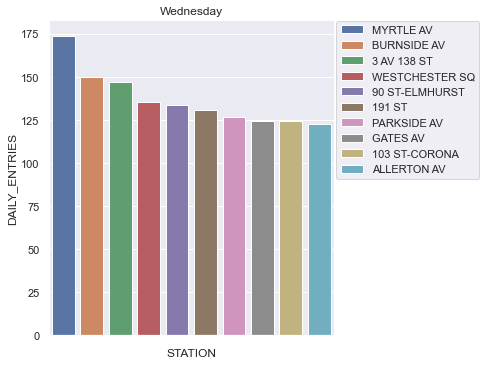

In [165]:
wed_results = create_results(wed_df)
create_bar_plot(wed_results)
plt.title('Wednesday')
plt.savefig('wed.png')

<Figure size 720x432 with 0 Axes>

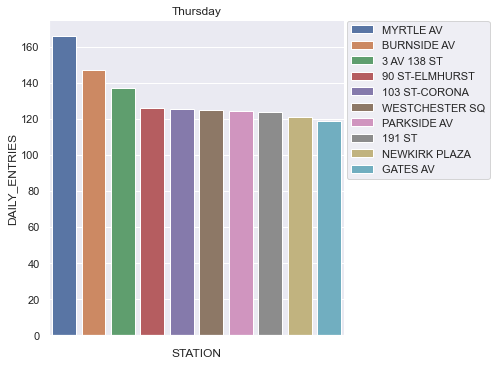

In [166]:
thu_results = create_results(thu_df)
create_bar_plot(thu_results)
plt.title('Thursday')
plt.savefig('thu.png')

<Figure size 720x432 with 0 Axes>

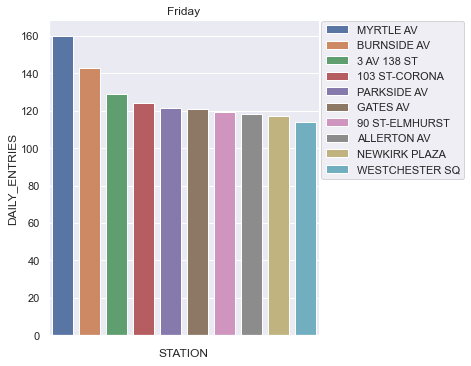

In [167]:
fri_results = create_results(fri_df)
create_bar_plot(fri_results)
plt.title('Friday')
plt.savefig('fri.png')

<Figure size 720x432 with 0 Axes>

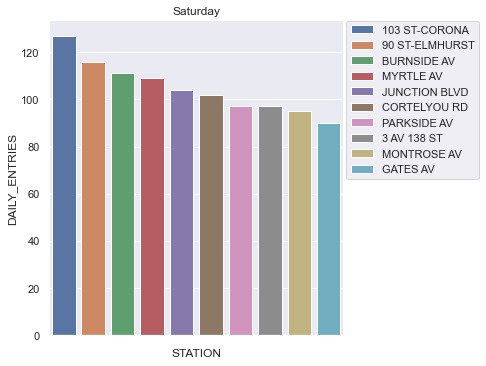

In [168]:
sat_results = create_results(sat_df)
create_bar_plot(sat_results)
plt.title('Saturday')
plt.savefig('sat.png')

<Figure size 720x432 with 0 Axes>

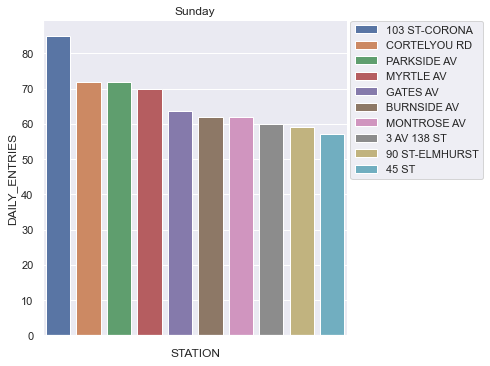

In [169]:
sun_results = create_results(sun_df)
create_bar_plot(sun_results)
plt.title('Sunday')
plt.savefig('sun.png')